# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [194]:
# Import stuff.
import networkx as nx
from ast import literal_eval

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [195]:
rules_data_path = 'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval
                       },
                       low_memory=True)

df_rules.head(5)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."


But just *how* many rules were just loaded‽

In [196]:
# Show the list of column names and the number of rules.
print(f"columns: {df_rules.columns} \n\n # of rules:{len(df_rules)}")

columns: Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items'],
      dtype='object') 

 # of rules:1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [197]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']

num = df_rules['item_set_count'] * df_rules['transaction_count']
den = df_rules['antecedent_count'] * df_rules['consequent_count']
df_rules['lift'] = num / den

df_rules[['consequent_item', 'support', 'confidence', 'lift', 'antecedent_items']].head(50)

,consequent_item,support,confidence,lift,antecedent_items
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,0.000030,0.821138,21465.598514,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,0.000030,0.789062,21465.598514,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
2,Total 0% with Honey Nonfat Greek Strained Yogurt,0.000030,0.821138,21465.598514,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
3,Total 0% Raspberry Yogurt,0.000030,0.821138,21465.598514,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
4,Pineapple Yogurt 2%,0.000030,0.789062,21465.598514,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
5,Fat Free Strawberry Yogurt,0.000030,0.821138,21465.598514,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
6,Fat Free Blueberry Yogurt,0.000030,0.789062,21465.598514,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
7,Total 2% with Raspberry Pomegranate Lowfat Gre...,0.000030,0.687075,19649.653061,"[Blackberry Yogurt, Fat Free Strawberry Yogurt..."
8,Total 2% Lowfat Greek Strained Yogurt With Blu...,0.000030,0.687075,19649.653061,"[Blackberry Yogurt, Fat Free Strawberry Yogurt..."
9,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,0.000030,0.863248,19649.653061,"[Pineapple Yogurt 2%, Total 0% Raspberry Yogur..."


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

most of the antecedents associated with the consequent are also yogurts. if lift tells us how likely our customer is to buy the consequent item given that they bought the antecedent items, then it's very likely that our customers often buy yogurt in bulk.

In [198]:
# Query the rule set if you have to to find out more.
def count_yogurt(df_col):
    count = 0
    for d in df_col:
        count += d.lower().count('yogurt')
    return count

yogurt_df = pd.DataFrame()
yogurt_df['consequent'] = df_rules['consequent_item'].apply(lambda x: 'yogurt' in x.lower())
yogurt_df['antecedent'] = df_rules['antecedent_items'].apply(lambda x: any('yogurt' in item.lower() for item in x))
yogurt_df['yogurt_count'] = df_rules['antecedent_items'].apply(count_yogurt)

yogurt_df['yogurt_count'].value_counts()

0    719614
3    116464
2     79471
4     66355
1     39863
5     22001
6      4333
7       456
8        18
Name: yogurt_count, dtype: int64

In [199]:
print(f"of the {yogurt_df['antecedent'].sum()} customers who bought at least 1 yogurt, "
       f"{yogurt_df['consequent'].sum()} of them bought additional yogurt")

yogurt_df[['consequent', 'antecedent']].corr()

of the 328961 customers who bought at least 1 yogurt, 301619 of them bought additional yogurt


,consequent,antecedent
consequent,1.00000,0.93434
antecedent,0.93434,1.00000


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [200]:
# Define df_rules_subset.

## 1
df_rules_subset = df_rules[df_rules['antecedent_items'].str.len() == 1]

## 2
df_rules_subset = df_rules_subset[(df_rules_subset['lift'] >= 5) & (df_rules_subset['lift'] <= 20)]

## 3
c1 = df_rules_subset['consequent_item'].apply(lambda x: 'hummus' in x.lower())
c2 = df_rules_subset['antecedent_items'].apply(lambda x: any('hummus' in item.lower() for item in x))

df_rules_subset = df_rules_subset[c1 ^ c2].reset_index(drop = True)

# df_rules_subset['consequent_item'] = df_rules_subset['consequent_item'].apply(
#     lambda x: "Hummus" if 'hummus' in x.lower() else x)



df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(
lambda x: "Hummus" if any('hummus' in item.lower() for item in x) else x)

df_rules_subset['antecedent_items'] = df_rules_subset['antecedent_items'].apply(
    lambda x: x[0] if isinstance(x, list) else x)


df_rules_subset

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,100,887,21405,Hummus,0.000030,0.112740,17.623731
1,Clementines,3346083,174,1334,32194,Hummus,0.000052,0.130435,13.556738
2,Original Hummus,3346083,345,1656,74172,Organic White Pita Bread,0.000103,0.208333,9.398434
3,Original Hummus,3346083,293,1434,74172,Organic Whole Wheat Pita,0.000088,0.204324,9.217543
4,Original Hummus,3346083,331,1655,74172,Mini Whole Wheat Pita Bread,0.000099,0.200000,9.022496
5,Original Hummus,3346083,3119,17333,74172,Sea Salt Pita Chips,0.000932,0.179946,8.117800
6,Organic Baby Carrots,3346083,258,1334,80493,Hummus,0.000077,0.193403,8.039749
7,Original Hummus,3346083,151,933,74172,"Lentil Chips, Himalayan Pink Salt",0.000045,0.161844,7.301163
8,Original Hummus,3346083,311,1929,74172,Garbanzo Beans No Salt Added,0.000093,0.161223,7.273189
9,Original Hummus,3346083,512,3333,74172,Organic Whole Peeled Baby Carrots,0.000153,0.153615,6.929970


Build a network `graph_rules_subset` from the association rules subset.

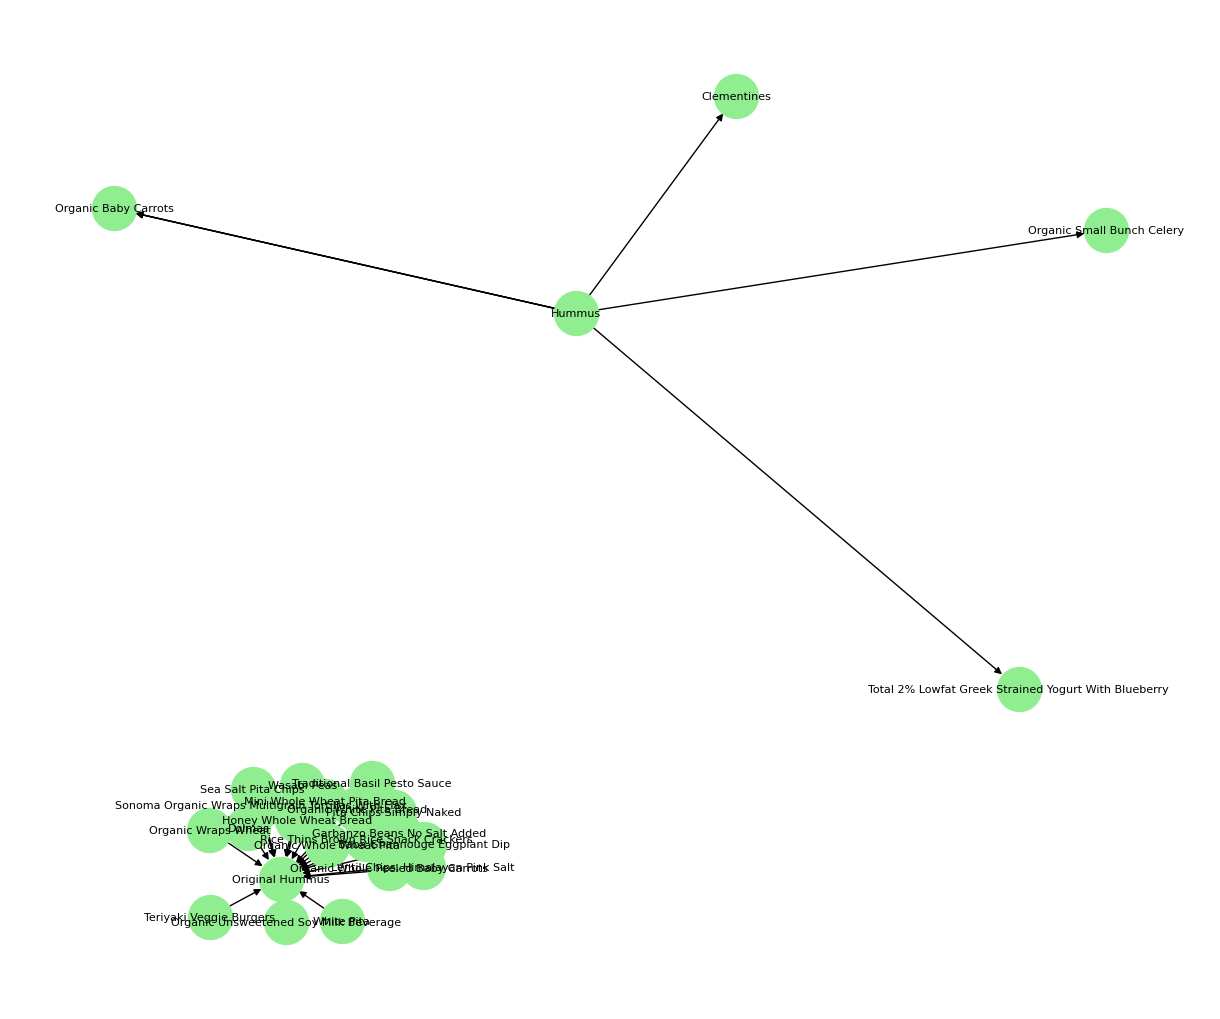

In [201]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.
graph_rules_subset = nx.MultiDiGraph()

edges = list(zip(df_rules_subset['antecedent_items'], df_rules_subset['consequent_item']))

graph_rules_subset.add_edges_from(edges)

plt.figure(figsize = (12, 10))

nx.draw(graph_rules_subset, 
        with_labels = True, 
        node_size = 1000, 
        node_color = 'lightgreen', 
        font_size = 8, 
        arrows = True)

# Then render the graph.
plt.show()

What can you tell about people who buy hummus?

they eat their veggies :)

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [223]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

## both
df_rules[df_rules['antecedent_items'].apply(lambda x: set(x).issuperset(basket))
         ] \
        .sort_values('lift', ascending=False) \
        .head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
363346,Organic Bell Pepper,3346083,116,494,24331,"[Green Bell Pepper, Orange Bell Pepper, Organi...",0.000035,0.234818,32.292955
363611,Organic Bell Pepper,3346083,124,536,24331,"[Bag of Organic Bananas, Orange Bell Pepper, O...",0.000037,0.231343,31.815126
364989,Organic Bell Pepper,3346083,582,2721,24331,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000174,0.213892,29.415159
366108,Organic Bell Pepper,3346083,114,564,24331,"[Orange Bell Pepper, Organic Red Bell Pepper, ...",0.000034,0.202128,27.797293
366942,Yellow Bell Pepper,3346083,105,494,26625,"[Green Bell Pepper, Orange Bell Pepper, Organi...",0.000031,0.212551,26.712187
367426,Organic Bell Pepper,3346083,112,591,24331,"[Banana, Orange Bell Pepper, Organic Red Bell ...",0.000033,0.189509,26.061973
370144,Yellow Bell Pepper,3346083,499,2721,26625,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000149,0.183388,23.047249
370225,Yellow Bell Pepper,3346083,108,591,26625,"[Banana, Orange Bell Pepper, Organic Red Bell ...",0.000032,0.182741,22.965895
393128,Green Bell Pepper,3346083,105,499,58005,"[Orange Bell Pepper, Organic Red Bell Pepper, ...",0.000031,0.210421,12.138361
395107,Green Bell Pepper,3346083,109,536,58005,"[Bag of Organic Bananas, Orange Bell Pepper, O...",0.000033,0.203358,11.730945


In [224]:
## either
df_rules[df_rules['antecedent_items'].apply(lambda x: len(set(x).intersection(basket)) > 0)
         ] \
        .sort_values('lift', ascending=False) \
        .head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
342462,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,100,209,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Ora...",0.000030,0.478469,80.202217
345882,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,132,311,19962,"[Non Fat Raspberry Yogurt, Orange Bell Pepper]",0.000039,0.424437,71.145298
346832,Nonfat Icelandic Style Strawberry Yogurt,3346083,100,441,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.226757,68.820769
346901,Non Fat Raspberry Yogurt,3346083,184,529,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000055,0.347826,68.651858
349532,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,184,494,19962,"[Non Fat Raspberry Yogurt, Organic Red Bell Pe...",0.000055,0.372470,62.434341
350852,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,167,471,19962,"[Organic Red Bell Pepper, Vanilla Skyr Nonfat ...",0.000050,0.354565,59.433078
350991,Non Fat Raspberry Yogurt,3346083,132,441,16953,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000039,0.299320,59.077960
351360,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,101,291,19962,"[Nonfat Icelandic Style Strawberry Yogurt, Org...",0.000030,0.347079,58.178302
351433,Nonfat Icelandic Style Strawberry Yogurt,3346083,101,529,11025,[Icelandic Style Skyr Blueberry Non-fat Yogurt...,0.000030,0.190926,57.946047
351881,Icelandic Style Skyr Blueberry Non-fat Yogurt,3346083,133,392,19962,"[Orange Bell Pepper, Vanilla Skyr Nonfat Yogurt]",0.000040,0.339286,56.871965


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.